In [ ]:
!pip install feature-engine

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import  scipy.stats as stats
import warnings
from feature_engine import transformation as vt
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Loading dataset
#Defining feature names
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

#Load dataset
data = pd.read_csv('/content/drive/MyDrive/CMaps/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)



In [ ]:
from sklearn.model_selection import train_test_split
from feature_engine.selection import DropConstantFeatures
#drop_features=['s_1', 's_5','s_6','s_10',  's_16', 's_18', 's_19']
setting_names = ['setting_1', 'setting_2', 'setting_3']
drop_labels = setting_names
drop_indexes = ['unit_number',  'time_cycles']
data=data.drop(columns=drop_labels).copy()
drop_features = DropConstantFeatures(tol = 0.98)
data = drop_features.fit_transform(data)
data

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [ ]:
sensors = [s for s in sensor_names if s  in data]
sensors

['s_2',
 's_3',
 's_4',
 's_7',
 's_8',
 's_9',
 's_11',
 's_12',
 's_13',
 's_14',
 's_15',
 's_17',
 's_20',
 's_21']

In [ ]:
def calcul_RUL(df):
    max_cycles = df[index_names].groupby('unit_number')['time_cycles'].max()
    df = df.merge(max_cycles.to_frame(name='max_cycles'), left_on='unit_number', right_index=True)
    df['RUL'] = df['max_cycles'] - df['time_cycles']
    df = df.drop('max_cycles', axis=1)
    return df

data = calcul_RUL(data)

In [ ]:
def diagnostic_plots(df,variable):
    #function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(data=df, x=variable, kde=True,color='brown',stat="density")
    plt.title('Histogram')

    # Q-Q plot
    ax=plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    ax.get_lines()[0].set_markersize(7.0)
    ax.get_lines()[0].set_markerfacecolor('green')
    ax.get_lines()[0].set_color('green')

    ax.get_lines()[1].set_markerfacecolor('red')
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=variable, data=df,color='#FADA5E',linewidth=2.5)
    sns.swarmplot(y=variable, data=df.iloc[0:300], color="#FADAFF")
    plt.title('Boxplot')

    plt.suptitle('Distribution of '+ variable, fontsize=16)
    plt.show()

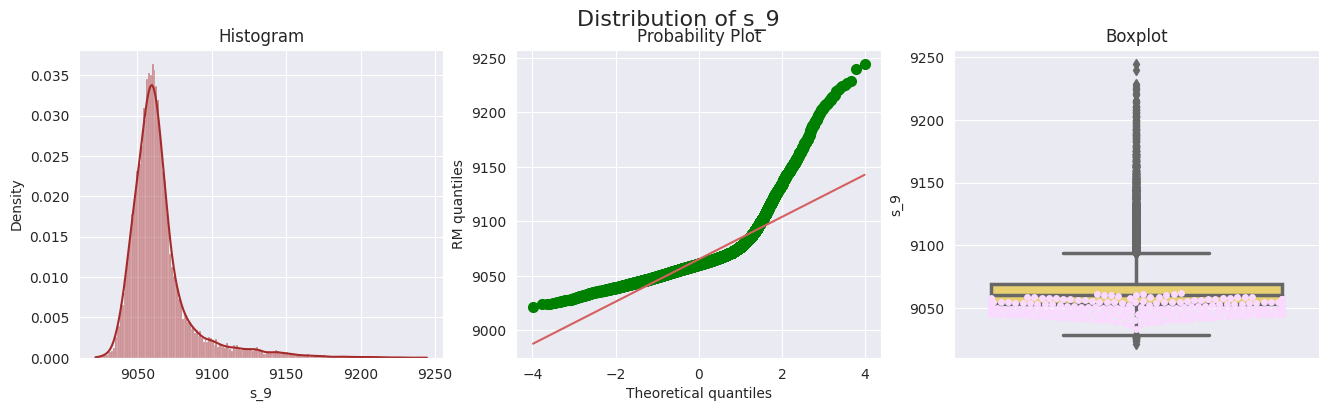

In [ ]:
warnings.filterwarnings('ignore')
for feature in ['s_9']:
  diagnostic_plots(data,feature)

In [ ]:
from sklearn.preprocessing import MinMaxScaler


scaler=MinMaxScaler()


dropped = data.drop(columns=['unit_number','time_cycles','RUL'])
scaler.fit(dropped)
norm=pd.DataFrame(scaler.transform(dropped),
                     columns=dropped.columns,index=dropped.index)
norm['unit_number'] = data['unit_number']
norm['time_cycles'] = data['time_cycles']
norm['RUL'] = data['RUL']
data = norm
del norm
data

,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,unit_number,time_cycles,RUL
0,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,1,1,191
1,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,1,2,190
2,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,1,3,189
3,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,1,4,188
4,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,1,5,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,0.686747,0.587312,0.782917,0.254428,0.439394,0.196491,0.726190,0.170576,0.558824,0.194344,0.656791,0.750000,0.271318,0.109500,100,196,4
20627,0.701807,0.729453,0.866475,0.162641,0.500000,0.194651,0.708333,0.211087,0.500000,0.188668,0.727203,0.583333,0.124031,0.366197,100,197,3
20628,0.665663,0.684979,0.775321,0.175523,0.515152,0.198196,0.738095,0.281450,0.529412,0.212148,0.922278,0.833333,0.232558,0.053991,100,198,2
20629,0.608434,0.746021,0.747468,0.133655,0.530303,0.233285,0.916667,0.208955,0.514706,0.203065,0.823394,0.583333,0.116279,0.234466,100,199,1


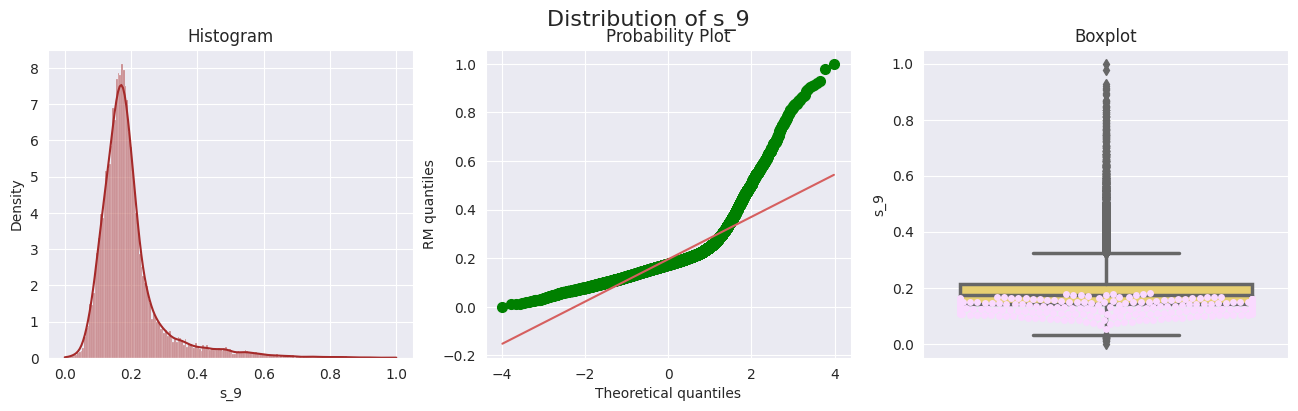

In [ ]:
warnings.filterwarnings('ignore')
for feature in ['s_9']:
  diagnostic_plots(data,feature)


In [ ]:
def view_tranformations(X_train,columns_names,transformation_name='YeoJohnson'):

  df_before = pd.DataFrame({'Skew':[X_train[feature].skew() for feature in columns_names],
                              'Feature':[feature for feature in columns_names]})

  if transformation_name in ['log','Log','LOG','ln','logaritmo natural']:
    tf = vt.LogTransformer(variables = columns_names)
    tf.fit(X_train)
    X_tf=tf.transform(X_train)
    df_after = pd.DataFrame({'Skew':[X_tf[feature].skew() for feature in columns_names],
                             'Feature':[feature for feature in columns_names]})
    label='Skewness before and after Log-Transformation'
  elif transformation_name in ['boxcox','Boxcox','box cox','box-cox','Box-cox','Box cox']:
    tf = vt.BoxCoxTransformer(variables = columns_names)
    tf.fit(X_train)
    X_tf=tf.transform(X_train)
    df_after = pd.DataFrame({'Skew':[X_tf[feature].skew() for feature in columns_names],
                                'Feature':[feature for feature in columns_names]})
    label='Skewness before and after Boxcox-Transformation'
  elif transformation_name in ['YeoJohnson','Yeo Johnson','Yeo-Johnson','yeojohnson','yeo johnson','yeo-johnson']:
    tf = vt.YeoJohnsonTransformer(variables = columns_names)
    tf.fit(X_train)
    X_tf=tf.transform(X_train)
    df_after = pd.DataFrame({'Skew':[X_tf[feature].skew() for feature in columns_names],
                                'Feature':[feature for feature in columns_names]})
    label='Skewness before and after YeoJohnson-Transformation'
  elif transformation_name in ['Reciprocal','Inverse','reciprocal','inverse','inverso','reciproco']:
    tf = vt.ReciprocalTransformer(variables = columns_names)
    tf.fit(X_train)
    X_tf=tf.transform(X_train)
    df_after = pd.DataFrame({'Skew':[X_tf[feature].skew() for feature in columns_names],
                                'Feature':[feature for feature in columns_names]})
    label='Skewness before and after Reciprocal-Transformation'
  else:
    raise Exception('\nColoque uma das transformações válidas:\nLog\nBox-Cox\nYeo-Johnson\nReciprocal')


  f, ax = plt.subplots(figsize=(6, 6))
  # Plot the total crashes
  sns.set_color_codes("muted")
  sns.set_style('darkgrid')
  sns.barplot(x="Skew", y="Feature", data=df_before,
              label="Before", alpha=0.5)

  # Plot the crashes where alcohol was involved
  sns.set_color_codes("muted")
  sns.barplot(x="Skew", y="Feature", data=df_after,
              label="After",alpha=1)

  # Add a legend and informative axis label
  ax.legend(ncol=2, loc="best", frameon=True)
  ax.set(ylabel="",
        xlabel=label)
  sns.despine(left=True, bottom=True)
  plt.grid()
  plt.show()

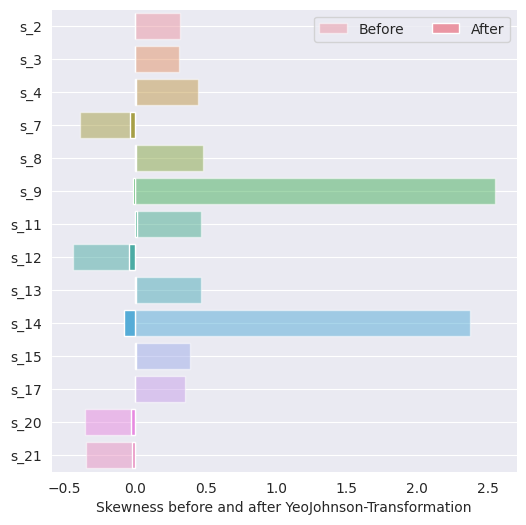

In [ ]:
view_tranformations(data,sensors)

In [ ]:
yeojohnson_transform=vt.YeoJohnsonTransformer(variables=sensors)
yeojohnson_transform.fit(data)
data=yeojohnson_transform.transform(data)

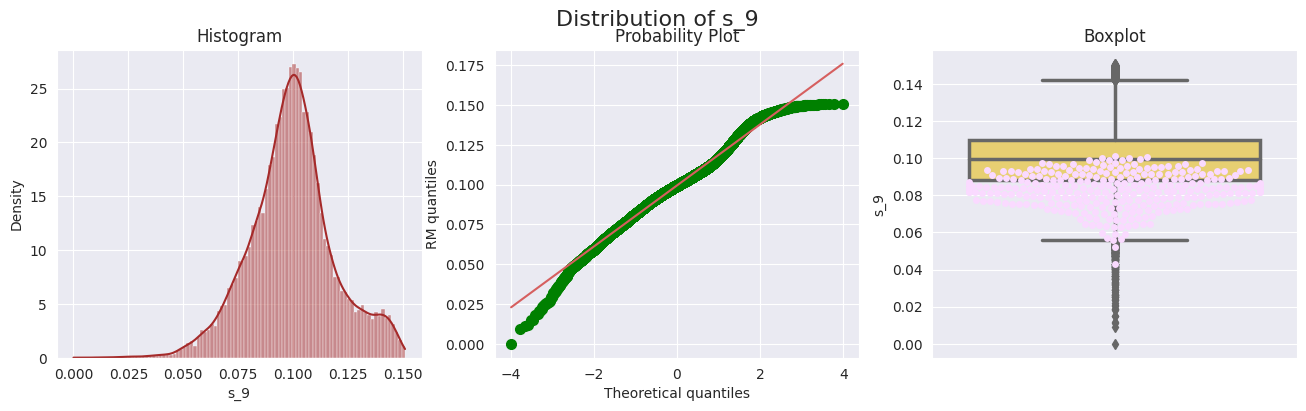

In [ ]:
warnings.filterwarnings('ignore')
for feature in ['s_9']:
  diagnostic_plots(data,feature)

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler=RobustScaler()

dropped = data.drop(columns=['unit_number','RUL'])
scaler.fit(dropped)
norm=pd.DataFrame(scaler.transform(dropped),
                     columns=dropped.columns,index=dropped.index)
norm['unit_number'] = data['unit_number']
norm['RUL'] = data['RUL']
norm['time_cycles'] = data['time_cycles']
data = norm
del norm
data

,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,time_cycles,unit_number,RUL
0,-1.355261,-0.049550,-0.663064,0.827954,-0.348801,-1.112874,-0.116787,0.186276,-0.757254,-0.130608,-0.399259,-0.521136,0.997796,0.896266,1,1,191
1,-0.774393,0.209125,-0.424769,0.265947,-0.596032,-1.320506,-0.057957,0.884234,-0.203946,-0.680343,-0.142433,-0.521136,0.722909,0.932616,2,1,190
2,-0.446680,-0.265448,-0.329137,0.732251,-0.113469,-0.534146,-0.758055,1.054226,-0.641269,-0.536029,-0.435810,-1.718829,0.501761,0.328948,3,1,189
3,-0.446680,-0.966117,-0.542261,0.915298,0.219029,-0.816091,-1.273754,1.619120,-0.100816,-0.487864,-1.634337,-0.521136,0.204129,0.548869,4,1,188
4,-0.414829,-0.957621,-0.152730,0.490007,-0.348801,-0.368683,-0.723498,0.777396,-0.528040,-0.490254,-0.191520,0.000000,0.287750,0.782023,5,1,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,1.149507,0.909987,1.405292,-1.421093,1.001981,0.279893,1.336175,-1.606795,1.423292,-0.202808,1.007686,1.712282,-1.206488,-1.845822,196,100,4
20627,1.210852,1.580910,1.674883,-1.734353,1.345517,0.257750,1.276153,-1.487020,1.131010,-0.282955,1.291325,0.920961,-1.748357,-0.884702,197,100,3
20628,1.062571,1.378043,1.379701,-1.692638,1.427061,0.300188,1.375595,-1.262952,1.279956,0.033571,1.993873,2.068488,-1.358015,-2.020762,198,100,2
20629,0.820160,1.654955,1.284228,-1.825578,1.506973,0.673228,1.915503,-1.493490,1.206205,-0.084259,1.651872,0.920961,-1.774356,-1.409612,199,100,1


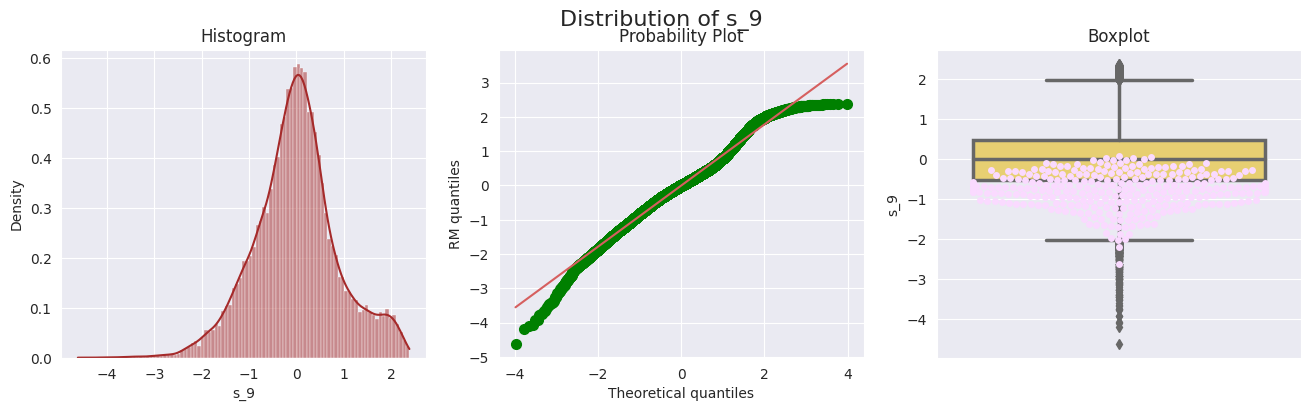

In [ ]:
warnings.filterwarnings('ignore')
for feature in ['s_9']:
  diagnostic_plots(data,feature)

In [ ]:
machines = data.groupby('unit_number')

n_groups = len(machines)

n_train = int(n_groups*0.7)
indices = np.array([* range(1,n_groups+1)])
indices_train = np.random.choice(indices, n_train, replace=False)
indices_test = np.setdiff1d(indices, indices_train)

machines_train = [group[1].sort_values(by='time_cycles') for i, group in enumerate(machines) if i+1 in indices_train]
machines_test = [group[1].sort_values(by='time_cycles') for i, group in enumerate(machines) if i+1 in indices_test]

In [ ]:
machines_train[0].head(30)

,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,time_cycles,unit_number,RUL
0,-1.355261,-0.049550,-0.663064,0.827954,-0.348801,-1.112874,-0.116787,0.186276,-0.757254,-0.130608,-0.399259,-0.521136,0.997796,0.896266,1,1,191
1,-0.774393,0.209125,-0.424769,0.265947,-0.596032,-1.320506,-0.057957,0.884234,-0.203946,-0.680343,-0.142433,-0.521136,0.722909,0.932616,2,1,190
2,-0.446680,-0.265448,-0.329137,0.732251,-0.113469,-0.534146,-0.758055,1.054226,-0.641269,-0.536029,-0.435810,-1.718829,0.501761,0.328948,3,1,189
3,-0.446680,-0.966117,-0.542261,0.915298,0.219029,-0.816091,-1.273754,1.619120,-0.100816,-0.487864,-1.634337,-0.521136,0.204129,0.548869,4,1,188
4,-0.414829,-0.957621,-0.152730,0.490007,-0.348801,-0.368683,-0.723498,0.777396,-0.528040,-0.490254,-0.191520,0.000000,0.287750,0.782023,5,1,187
5,-0.859055,-0.732026,-0.883652,1.133678,-0.856083,-0.798985,-1.157961,0.207420,-0.641269,-0.566951,-0.589150,-1.091289,0.633589,0.496405,6,1,186
6,-0.242487,0.268750,-0.944937,0.808700,-0.856083,-0.096516,-0.456922,0.932329,-0.641269,-0.610629,-0.896114,-0.521136,1.186868,0.575248,7,1,185
7,-0.120065,-0.942073,-0.627519,0.354536,-1.129974,-1.668626,-0.863462,1.116067,-0.641269,-0.716241,-0.660811,-1.091289,0.589360,0.088554,8,1,184
8,-0.825054,0.107782,-1.261257,0.213452,-0.470874,-1.087384,-0.689223,0.325326,-0.417471,-1.215841,-1.511091,-0.521136,0.951257,0.799128,9,1,183
9,-1.561288,0.139309,-0.676590,0.127054,-0.470874,-0.631852,-1.682995,0.325326,-0.309469,-0.865050,-0.207991,0.000000,0.501761,1.303846,10,1,182


In [ ]:
def transform_rul_to_rulw(rul):
    classes = 7 #classes
    rulw = rul//7
    if rulw> (classes-2):
        rulw= classes-1
    y = np.zeros(classes)
    y[rulw] = 1
    return y

In [ ]:
T = 25
X_train = []
y_train = []
X_test = []
y_test = []

for machine in machines_train:
  for i in range(machine.shape[0]-T):
    X_train.append(machine[sensors][i:i+T].to_numpy())
    y_train.append(transform_rul_to_rulw(int(machine['RUL'].iloc[i+T])))

for machine in machines_test:
  for i in range(machine.shape[0]-T):
    X_test.append(machine[sensors][i:i+T].to_numpy())
    y_test.append(transform_rul_to_rulw(int(machine['RUL'].iloc[i+T])))

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
def get_loaders(X_train,X_test,y_train,y_test,batch_size):
  X_train_tensor = torch.Tensor(X_train)
  X_test_tensor = torch.Tensor(X_test)
  y_train_tensor = torch.Tensor(y_train)
  y_test_tensor = torch.Tensor(y_test)

  train_data = TensorDataset(X_train_tensor,y_train_tensor)
  test_data = TensorDataset(X_test_tensor,y_test_tensor)

  train_loader = DataLoader(train_data,batch_size=batch_size)
  test_loader = DataLoader(test_data,batch_size=batch_size)

  return train_loader,test_loader

In [ ]:
train_loader,test_loader = get_loaders(X_train,X_test,y_train,y_test,batch_size=256)

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss >= (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def train_model(model,device,train_loader,test_loader,optimizer,criterion,scheduler,n_epochs):

  mean_loss_train = []
  mean_loss_test = []
  mean_f1_scores_train = []
  mean_f1_scores_test = []

  early_stopper = EarlyStopper(patience=999, min_delta=0)
  for it in range(n_epochs):
    train_loss = []
    f1_scores_train = []
    model.train()
    for inputs,targets in train_loader:
      inputs,targets = inputs.to(device),targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = torch.sum(criterion(outputs,targets))
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      y_true = targets.argmax(dim=1).cpu().numpy().reshape(targets.size(0))
      y_pred = outputs.argmax(dim=1).cpu().numpy()
      f1_step = precision_recall_fscore_support(y_true, y_pred, average='weighted')[2]
      f1_scores_train.append(f1_step)

    mean_loss_train.append(np.mean(train_loss))
    mean_f1_scores_train.append(np.mean(f1_scores_train))

    with torch.no_grad():
      model.eval()
      test_loss = []
      f1_scores_test =[]
      for inputs,targets in test_loader:
        inputs,targets = inputs.to(device),targets.to(device)
        outputs = model(inputs)
        loss = torch.sum(criterion(outputs,targets))
        test_loss.append(loss.item())
        y_true = targets.argmax(dim=1).cpu().numpy().reshape(targets.size(0))
        y_pred = outputs.argmax(dim=1).cpu().numpy()
        f1_step = precision_recall_fscore_support(y_true, y_pred, average='weighted')[2]
        f1_scores_test.append(f1_step)

    test_loss = np.mean(test_loss)
    mean_loss_test.append(test_loss)
    mean_f1_scores_test.append(np.mean(f1_scores_test))

    scheduler.step()

    print(f'Epoch {it}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Test Loss:{mean_loss_test[-1]:.4f}, F1 Score Train: {mean_f1_scores_train[-1]:.4f}, F1 Score Test: {mean_f1_scores_test[-1]:.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]}')

    if early_stopper.early_stop(test_loss):
      break

  return mean_loss_train,mean_loss_test,mean_f1_scores_train,mean_f1_scores_test

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# RNN

In [ ]:
class Flatten2d(nn.Module):
    def __init__(self,n_neurons_flatten):
      super(Flatten2d,self).__init__()
      self.n_neurons_flatten = n_neurons_flatten
    def forward(self, x):
        return x.contiguous().view(-1,self.n_neurons_flatten)

class SimpleRNN(nn.Module):
  def __init__(self,
               input_size,
               hidden_size,
               sequence_length,
               num_layers,
               rnn_activation_function,
               fc_activation_function,
               final_activation_function,
               fc_num_neurons,
               num_classes,
               device):
    super(SimpleRNN,self).__init__()

    self.L = sequence_length
    self.Hin = input_size
    self.Hout = hidden_size
    self.rnn_activation_function = rnn_activation_function
    self.num_layers = num_layers
    self.final_activation_function = final_activation_function
    self.num_classes = num_classes
    self.fc_num_neurons = fc_num_neurons


    self.input_shape = (self.L,self.Hin)
    self.rnn = nn.RNN(input_size =  self.Hin,
                      hidden_size = self.Hout,
                      num_layers =  self.num_layers,
                      nonlinearity = self.rnn_activation_function,
                      batch_first=True)
    self.n_neurons_flatten = int(self.Hout*self.L)
    self.flatten = Flatten2d(self.n_neurons_flatten)
    self.fc = nn.Sequential(nn.Linear(self.n_neurons_flatten,self.fc_num_neurons),
                            fc_activation_function(),
                            nn.Linear(self.fc_num_neurons,self.num_classes))
    self.device = device


  def forward(self,x):
    h0 = torch.zeros(size=(self.num_layers,x.size(0),self.Hout)).to(device)
    x,_ = self.rnn(x,h0)
    x = self.flatten(x)
    x = self.fc(x)
    x = self.final_activation_function(x)
    return x


In [ ]:
model = SimpleRNN(input_size=14,
                  hidden_size=128,
                  sequence_length=T,
                  num_layers=1,
                  rnn_activation_function='tanh',
                  fc_activation_function=nn.GELU,
                  final_activation_function = nn.Softmax(dim=1),
                  fc_num_neurons=128,
                  num_classes=7,
                  device=device
                  )

model.to(device)

SimpleRNN(
  (final_activation_function): Softmax(dim=1)
  (rnn): RNN(14, 128, batch_first=True)
  (flatten): Flatten2d()
  (fc): Sequential(
    (0): Linear(in_features=3200, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=7, bias=True)
  )
)

In [ ]:
def rul_metric(targets, values):

    error = 0
    for value, target in zip(values, targets):
        if value >= target:
            error += np.exp((value - target)/10) -1
        else:
            error += np.exp(-(value - target)/13) -1

    return error

In [ ]:
from typing import Optional
import torch.nn.functional as F

#from .one_hot import one_hot

In [ ]:
pip install torchvision


In [ ]:
from torchvision import ops

In [ ]:
criterion = ops.sigmoid_focal_loss
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)

scheduler = ExponentialLR(optimizer, gamma=0.999)

In [ ]:
mean_loss_train,mean_loss_test,mean_f1_scores_train,mean_f1_scores_test = train_model(model,device,train_loader,test_loader,optimizer,criterion,scheduler,n_epochs=50)

Epoch 0/50, Train Loss: 236.8797, Test Loss:219.2876, F1 Score Train: 0.6853, F1 Score Test: 0.7231, Learning Rate: 9.99e-05
Epoch 1/50, Train Loss: 218.7141, Test Loss:218.7861, F1 Score Train: 0.7384, F1 Score Test: 0.7418, Learning Rate: 9.980010000000001e-05
Epoch 2/50, Train Loss: 218.3021, Test Loss:218.5470, F1 Score Train: 0.7505, F1 Score Test: 0.7533, Learning Rate: 9.970029990000001e-05
Epoch 3/50, Train Loss: 218.0749, Test Loss:218.3249, F1 Score Train: 0.7577, F1 Score Test: 0.7596, Learning Rate: 9.960059960010001e-05
Epoch 4/50, Train Loss: 217.8523, Test Loss:218.0942, F1 Score Train: 0.7629, F1 Score Test: 0.7625, Learning Rate: 9.950099900049991e-05
Epoch 5/50, Train Loss: 217.6140, Test Loss:217.8340, F1 Score Train: 0.7692, F1 Score Test: 0.7655, Learning Rate: 9.94014980014994e-05
Epoch 6/50, Train Loss: 217.3508, Test Loss:217.5321, F1 Score Train: 0.7732, F1 Score Test: 0.7664, Learning Rate: 9.930209650349791e-05
Epoch 7/50, Train Loss: 217.0727, Test Loss:217.

In [ ]:
def plot_model_loss_metrics(mean_loss_train,mean_loss_test):
  plt.plot(mean_loss_train,label='Train')
  plt.plot(mean_loss_test,label='Test')
  plt.title('Loss - Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

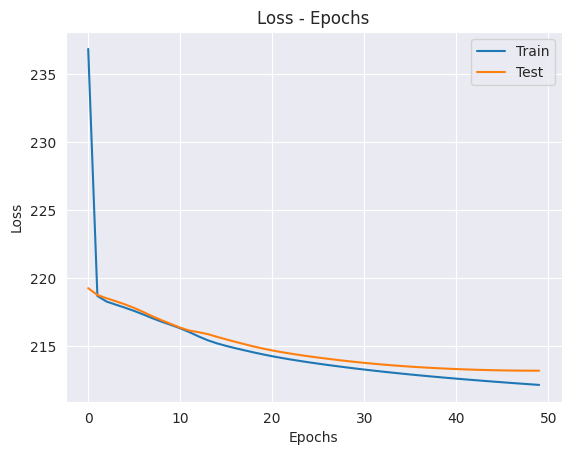

In [ ]:
plot_model_loss_metrics(mean_loss_train,mean_loss_test)

In [ ]:
def plot_model_f1_metrics(mean_f1_scores_train,mean_f1_scores_test):
  plt.plot(mean_f1_scores_train,label='Train')
  plt.plot(mean_f1_scores_test,label='Test')
  plt.title('F1 - Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('F1')
  plt.legend()
  plt.show()

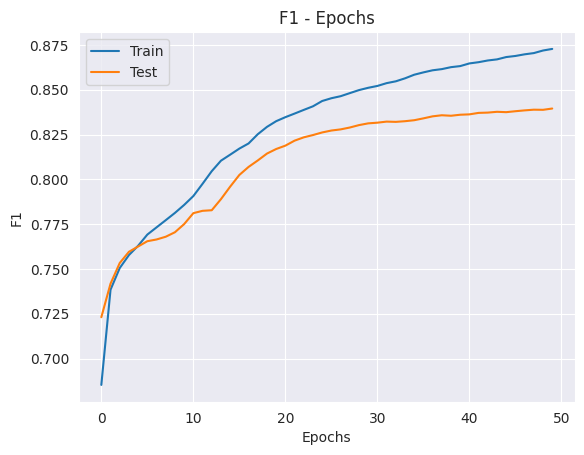

In [ ]:
plot_model_f1_metrics(mean_f1_scores_train,mean_f1_scores_test)

In [ ]:
with torch.no_grad():
     model.eval()
     for inputs,targets in test_loader:
          inputs,targets = inputs.to(device),targets.to(device)
          outputs = model(inputs)
          break

Accuracy: 0.8789
Precision: 0.8490
Recall: 0.8789
F1 Score: 0.8610
Classification Report:
               precision    recall  f1-score   support

           0       0.47      1.00      0.64         7
           1       0.00      0.00      0.00         7
           2       0.10      0.14      0.12         7
           3       0.33      0.43      0.38         7
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         7
           6       0.99      1.00      0.99       214

    accuracy                           0.88       256
   macro avg       0.27      0.37      0.30       256
weighted avg       0.85      0.88      0.86       256



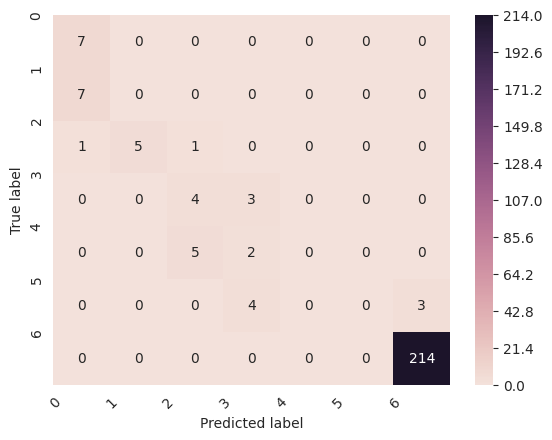

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

def plot_confusion_matrix(y_true, y_pred, classes, threshold_value=50):
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    fig, ax = plt.subplots()

    # Saturate the colors in the colormap
    cmap = sns.cubehelix_palette(dark=0.1, light=0.9, as_cmap=True)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, ax=ax)

    # Set labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Colorbar
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(np.linspace(0, cm.max(), 11))


y_true = targets.argmax(dim=1).cpu().numpy().reshape(targets.size(0))
y_pred = outputs.argmax(dim=1).cpu().numpy()

# Get unique class labels
classes = unique_labels(y_true, y_pred)

# Calculate metrics
accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes)

# Print classification report
report = classification_report(y_true, y_pred, target_names=[str(cls) for cls in classes])
print("Classification Report:\n", report)

plt.show()


In [ ]:
outputs

In [ ]:
outputs.argmax(dim=1).cpu().numpy()

# LSTM

In [ ]:
class Flatten2d(nn.Module):
    def __init__(self,n_neurons_flatten):
      super(Flatten2d,self).__init__()
      self.n_neurons_flatten = n_neurons_flatten
    def forward(self, x):
        return x.contiguous().view(-1,self.n_neurons_flatten)

class SimpleLSTM(nn.Module):
  def __init__(self,
               input_size,
               hidden_size,
               sequence_length,
               num_layers,
               rnn_activation_function,
               fc_activation_function,
               final_activation_function,
               fc_num_neurons,
               num_classes,
               device):

    super(SimpleLSTM,self).__init__()

    self.L = sequence_length
    self.Hin = input_size
    self.Hout = hidden_size
    self.Hcell = hidden_size
    self.rnn_activation_function = rnn_activation_function
    self.num_layers = num_layers
    self.final_activation_function = final_activation_function
    self.num_classes = num_classes
    self.fc_num_neurons = fc_num_neurons


    self.input_shape = (self.L,self.Hin)
    self.lstm = nn.LSTM(input_size=self.Hin,
                        hidden_size=self.Hcell,
                        num_layers=self.num_layers,
                        batch_first=True)
    self.n_neurons_flatten = int(self.Hout*self.L)
    self.flatten = Flatten2d(self.n_neurons_flatten)
    self.fc = nn.Sequential(nn.Linear(self.n_neurons_flatten,self.fc_num_neurons),
                            fc_activation_function(),
                            nn.Linear(self.fc_num_neurons,self.num_classes))
    self.device = device


  def forward(self,x):

    x,_ = self.lstm(x)
    x = self.flatten(x)
    x = self.fc(x)
    x = self.final_activation_function(x)
    return x

In [ ]:
model = SimpleLSTM(input_size=14,
                  hidden_size=128,
                  sequence_length=T,
                  num_layers=1,
                  rnn_activation_function='tanh',
                  fc_activation_function=nn.GELU,
                  final_activation_function = nn.Softmax(dim=1),
                  fc_num_neurons=128,
                  num_classes=classes+2,
                  device=device
                  )

model.to(device)

TypeError: ignored

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.999)

In [ ]:
mean_loss_train,mean_loss_test,mean_f1_scores_train,mean_f1_scores_test = train_model(model,device,train_loader,test_loader,optimizer,criterion,scheduler,n_epochs=20)

In [ ]:
plot_model_loss_metrics(mean_loss_train,mean_loss_test)

In [ ]:
plot_model_f1_metrics(mean_f1_scores_train,mean_f1_scores_test)

In [ ]:
with torch.no_grad():
     model.eval()
     for inputs,targets in test_loader:
          inputs,targets = inputs.to(device),targets.to(device)
          outputs = model(inputs)
          break

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

def plot_confusion_matrix(y_true, y_pred, classes, threshold_value=50):
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    fig, ax = plt.subplots()

    # Saturate the colors in the colormap
    cmap = sns.cubehelix_palette(dark=0.1, light=0.9, as_cmap=True)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, ax=ax)

    # Set labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Colorbar
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(np.linspace(0, cm.max(), 11))


y_true = targets.argmax(dim=1).cpu().numpy().reshape(targets.size(0))
y_pred = outputs.argmax(dim=1).cpu().numpy()

# Get unique class labels
classes = unique_labels(y_true, y_pred)

# Calculate metrics
accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes)

# Print classification report
report = classification_report(y_true, y_pred, target_names=[str(cls) for cls in classes])
print("Classification Report:\n", report)

plt.show()
